# Centering script

In [1]:
# Basics
import numpy as np
import pandas as pd
import os

# Scipy
from scipy import optimize
from scipy.ndimage import gaussian_filter
#from sklearn.neighbors import KDTree
from scipy import stats

# Plotting
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, FormatStrFormatter, AutoMinorLocator, AutoLocator, MaxNLocator
import matplotlib.gridspec as gridspec
from matplotlib.colorbar import Colorbar
import matplotlib.colors as mcolors
from matplotlib import colors
import matplotlib.ticker as ticker
from matplotlib import rcParams
from mpl_toolkits.mplot3d import Axes3D
from scipy.optimize import curve_fit

# RC params
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 14
rcParams["axes.edgecolor"] = 'black'
rcParams["legend.edgecolor"] = '0.8'
plt.rcParams.update({'errorbar.capsize': 2})
plt.rcParams['mathtext.fontset'] = 'dejavuserif'
plt.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]

def fmt(x, pos):
    ''' Used for the x10^ for colourbars'''
    if x == 0:
        return r'0'
    a, b = '{:.1e}'.format(x).split('e')
    b = int(b)
    return r'${} \times 10^{{{}}}$'.format(a, b)

## Correct model to run

In [2]:
model_path = "/Users/maddie/Desktop/Thesis/Simulation_output/K_Magellan/runw46"
#model_path = "/Users/maddie/Desktop/Thesis/Simulation_output/1_phase_revisions/run3"
os.chdir(model_path)

## Start with only the original iwas location

In [3]:
col_header = ['x', 'y', 'z', 'vx', 'vy', 'vz', 'iwas', 'id', 'mass']

old = np.load('old.npy') # Need old to get iwas
iwas4 = [old[0,0], old[0,1], old[0,2]]
#iwas4 = [-33.7673, 444.823, -18.1474] #Centered using other script

old = pd.DataFrame(old, columns=col_header)


new = np.load('new.npy')
new = pd.DataFrame(new, columns=col_header)

In [4]:
gal = np.load('gal.npy')
gal = pd.DataFrame(gal, columns=col_header)

gas = np.load('gas.npy')
gas = pd.DataFrame(gas, columns=col_header)


In [5]:
old = old.assign(x_scale = old.x - iwas4[0])
old = old.assign(y_scale = old.y - iwas4[1])
old = old.assign(z_scale = old.z - iwas4[2])

new = new.assign(x_scale = new.x - iwas4[0])
new = new.assign(y_scale = new.y - iwas4[1])
new = new.assign(z_scale = new.z - iwas4[2])



In [6]:
v_init = np.sqrt(np.average(old.vx)**2 + np.average(old.vy)**2)
print(v_init)
print(np.average(old.vx))
print(np.average(old.vy))
print(np.average(old.vz))

26.07370167601059
-25.79938126995052
-3.772246701545886
-0.24653083343312573


In [7]:
i = 5 # get within 5 pc
old_crop = old.loc[(old.y_scale<i)&(old.y_scale>-i)&(old.x_scale<i)&(old.x_scale>-i)&(old.z_scale<i)&(old.z_scale>-i)]
new_crop = new.loc[(new.y_scale<i)&(new.y_scale>-i)&(new.x_scale<i)&(new.x_scale>-i)&(new.z_scale<i)&(new.z_scale>-i)]


### Changing directory to new folder

In [8]:
path = "centering_output"
try:
    os.mkdir(path)
except OSError:
    print ("Creation of the directory %s failed" % path)
else:
    print ("Successfully created the directory %s" % path)
    
    
os.chdir(path)

Creation of the directory centering_output failed


#### The COM will be influenced by the position of the new stars
- this should be taken into account by performing the KDE on both the old and new stars
seeing as the new stars are so turbulent and unsettled, just use the old stars - going to be easier to find the maximum

## Check current position

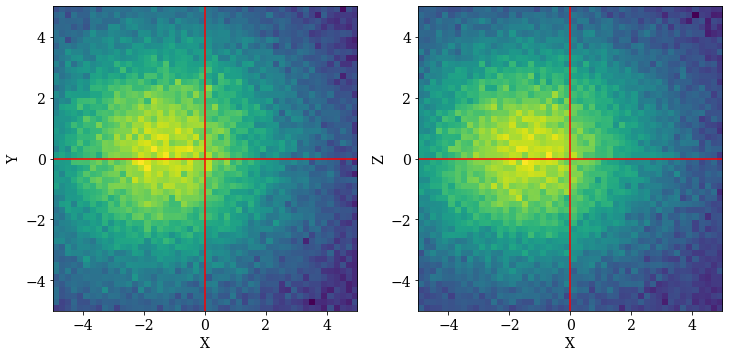

In [9]:
rang = i
# previous -> bins = rang*2
bin_size = 50
gamma = 0.5

old_bin1, xedges, yedges = np.histogram2d(old_crop.x_scale, old_crop.y_scale, bins = bin_size, weights = old_crop.mass, range=([-rang,rang],[-rang,rang]))
old_bin2, xedges, yedges = np.histogram2d(old_crop.x_scale, old_crop.z_scale, bins = bin_size, weights = old_crop.mass, range=([-rang,rang],[-rang,rang]))

fig, ax = plt.subplots(1,2)
fig.set_size_inches(12,6)
ax[0].imshow(old_bin1.T, norm=mcolors.PowerNorm(gamma), 
             origin='lower', extent=[-rang, rang, -rang, rang])
ax[0].hlines(0,-5,5, 'r')
ax[0].vlines(0,-5,5, 'r')
ax[0].set_ylabel('Y')
ax[0].set_xlabel('X')

ax[1].imshow(old_bin2.T, norm=mcolors.PowerNorm(gamma), 
             origin='lower', extent=[-rang, rang, -rang, rang])
ax[1].hlines(0,-5,5, 'r')
ax[1].vlines(0,-5,5, 'r')
ax[1].set_ylabel('Z')
ax[1].set_xlabel('X')

plt.savefig('original_centering')
plt.show()

## Perform Kernal Density Estimation

In [10]:
xyz = np.vstack([old_crop.x_scale, old_crop.y_scale, old_crop.z_scale])
kde = stats.gaussian_kde(xyz, weights = old_crop.mass, bw_method = 'silverman')
density = kde(xyz)
np.save("kde", density)

In [11]:
max_density = np.argmax(density)
max_dense_x = old_crop.x_scale.iloc[max_density]
max_dense_y = old_crop.y_scale.iloc[max_density]
max_dense_z = old_crop.z_scale.iloc[max_density]

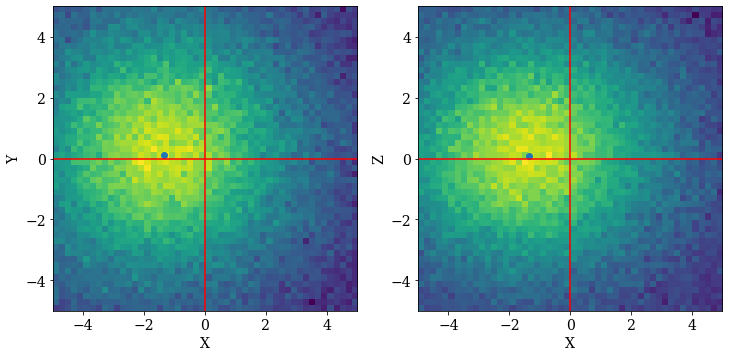

In [12]:
fig, ax = plt.subplots(1,2)
fig.set_size_inches(12,6)
ax[0].imshow(old_bin1.T, norm=mcolors.PowerNorm(gamma), 
             origin='lower', extent=[-rang, rang, -rang, rang])
ax[0].scatter(max_dense_x,max_dense_y)
ax[0].hlines(0,-5,5, 'r')
ax[0].vlines(0,-5,5, 'r')
ax[0].set_ylabel('Y')
ax[0].set_xlabel('X')

ax[1].imshow(old_bin2.T, norm=mcolors.PowerNorm(gamma), 
             origin='lower', extent=[-rang, rang, -rang, rang])
ax[1].scatter(max_dense_x, max_dense_z)
ax[1].hlines(0,-5,5, 'r')
ax[1].vlines(0,-5,5, 'r')
ax[1].set_ylabel('Z')
ax[1].set_xlabel('X')


plt.savefig('KDE_estimation')

plt.show()

In [13]:
old = old.assign(x_scale = old.x - max_dense_x - iwas4[0])
old = old.assign(y_scale = old.y - max_dense_y - iwas4[1])
old = old.assign(z_scale = old.z - max_dense_z - iwas4[2])

new = new.assign(x_scale = new.x - max_dense_x - iwas4[0])
new = new.assign(y_scale = new.y - max_dense_y - iwas4[1])
new = new.assign(z_scale = new.z - max_dense_z - iwas4[2])

## Final result

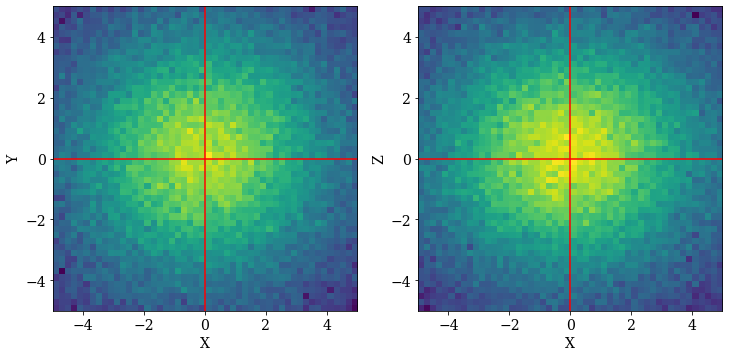

In [14]:
old_bin1, xedges, yedges = np.histogram2d(old.x_scale, old.y_scale, bins = bin_size, weights = old.mass, range=([-rang,rang],[-rang,rang]))
old_bin2, xedges, yedges = np.histogram2d(old.x_scale, old.z_scale, bins = bin_size, weights = old.mass, range=([-rang,rang],[-rang,rang]))

fig, ax = plt.subplots(1,2)
fig.set_size_inches(12,6)
ax[0].imshow(old_bin1.T, norm=mcolors.PowerNorm(gamma), 
             origin='lower', extent=[-rang, rang, -rang, rang])
ax[0].hlines(0,-5,5, 'r')
ax[0].vlines(0,-5,5, 'r')
ax[0].set_ylabel('Y')
ax[0].set_xlabel('X')

ax[1].imshow(old_bin2.T, norm=mcolors.PowerNorm(gamma), 
             origin='lower', extent=[-rang, rang, -rang, rang])
ax[1].hlines(0,-5,5, 'r')
ax[1].vlines(0,-5,5, 'r')
ax[1].set_ylabel('Z')
ax[1].set_xlabel('X')

plt.savefig('after_centering')
plt.show()

In [15]:
old = old.assign(r = np.power(np.power(old.x_scale,2) + np.power(old.y_scale,2) + np.power(old.z_scale,2), 0.5))
new = new.assign(r = np.power(np.power(new.x_scale,2) + np.power(new.y_scale,2) + np.power(new.z_scale,2), 0.5))

## Basic histograms

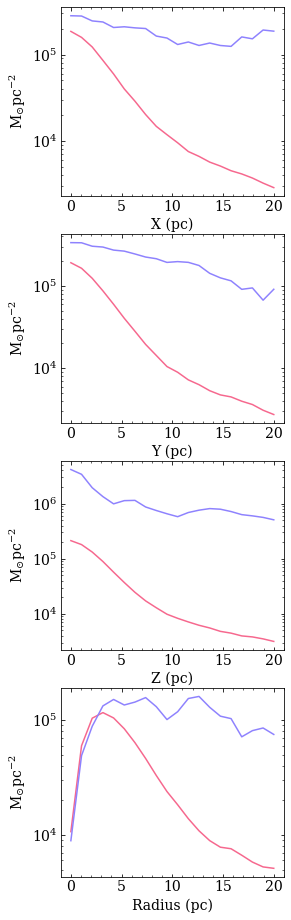

In [16]:
new_col = 'xkcd:periwinkle'
old_col = 'xkcd:rosy pink'

binning = 20
max_range = 20

x_range = np.linspace(0,max_range,binning)

old_x_hist,_,_ = stats.binned_statistic(abs(old.x_scale), values = old.mass, bins=binning, 
                                            range=(0, max_range), statistic='sum')
old_y_hist,_,_ = stats.binned_statistic(abs(old.y_scale), values = old.mass, bins=binning, 
                                           range=(0, max_range), statistic='sum')
old_z_hist,_,_ = stats.binned_statistic(abs(old.z_scale), values = old.mass, bins=binning, 
                                            range=(0, max_range), statistic='sum')
old_r_hist,_,_ = stats.binned_statistic(old.r, values = old.mass, bins=binning, 
                                            range=(0, max_range), statistic='sum')
old_r_std,_,_ = stats.binned_statistic(old.r, values = old.mass, bins=binning, 
                                            range=(0, max_range), statistic='std')

new_x_hist,_,_ = stats.binned_statistic(abs(new.x_scale), values = new.mass, bins=binning, 
                                            range=(0, max_range), statistic='sum')
new_y_hist,_,_ = stats.binned_statistic(abs(new.y_scale), values = new.mass, bins=binning, 
                                           range=(0, max_range), statistic='sum')
new_z_hist,_,_ = stats.binned_statistic(abs(new.z_scale), values = new.mass, bins=binning, 
                                            range=(0, max_range), statistic='sum')
new_r_hist,_,_ = stats.binned_statistic(new.r, values = new.mass, bins=binning, 
                                            range=(0, max_range), statistic='sum')
new_r_std,_,_ = stats.binned_statistic(new.r, values = new.mass, bins=binning, 
                                            range=(0, max_range), statistic='std')

fig, ax = plt.subplots(4)
fig.set_size_inches(4,16)
ax[0].plot(x_range, old_x_hist, color = old_col)
ax[0].plot(x_range, new_x_hist, color = new_col)
ax[0].set_xlabel('X (pc)')
ax[0].set_ylabel(r'$\rm{M}_{\odot}pc^{-2}$')
ax[0].set_yscale('log')
ax[0].xaxis.set_minor_locator(AutoMinorLocator())
ax[0].tick_params(direction='in', axis='both', which='both', bottom=True,top=True, left=True, right=True)

ax[1].plot(x_range, old_y_hist, color = old_col)
ax[1].plot(x_range, new_y_hist, color = new_col)
ax[1].set_xlabel('Y (pc)')
ax[1].set_ylabel(r'$\rm{M}_{\odot}pc^{-2}$')
ax[1].set_yscale('log')
ax[1].xaxis.set_minor_locator(AutoMinorLocator())
ax[1].tick_params(direction='in', axis='both', which='both', bottom=True,top=True, left=True, right=True)

ax[2].plot(x_range, old_z_hist, color = old_col)
ax[2].plot(x_range, new_z_hist, color = new_col)
ax[2].set_xlabel('Z (pc)')
ax[2].set_ylabel(r'$\rm{M}_{\odot}pc^{-2}$')
ax[2].set_yscale('log')
ax[2].xaxis.set_minor_locator(AutoMinorLocator())
ax[2].tick_params(direction='in', axis='both', which='both', bottom=True,top=True, left=True, right=True)

ax[3].plot(x_range, old_r_hist, color = old_col)
ax[3].plot(x_range, new_r_hist, color = new_col)
ax[3].set_xlabel('Radius (pc)')
ax[3].set_ylabel(r'$\rm{M}_{\odot}pc^{-2}$')
ax[3].set_yscale('log')
ax[3].xaxis.set_minor_locator(AutoMinorLocator())
ax[3].tick_params(direction='in', axis='both', which='both', bottom=True,top=True, left=True, right=True)

plt.savefig('radial_hist',bbox_inches='tight', dpi = 300)
plt.show()

## F_enriched plot

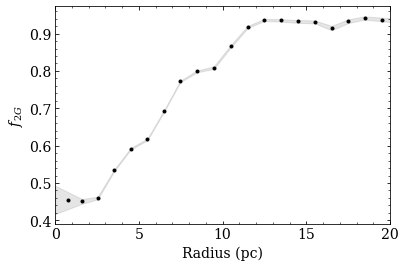

In [17]:
std_f = np.sqrt((new_r_std/new_r_hist)**2 + ((new_r_std+old_r_std))/(new_r_hist+old_r_hist)**2)

bin_centers, _, _ = stats.binned_statistic(new.r, values = new.r, statistic='mean',bins=binning, range=(0, max_range))
x_range = np.copy(bin_centers)
x_range[0] = 0
x_range[-1] = max_range

f_enriched = new_r_hist/(old_r_hist+new_r_hist)
f_lower = f_enriched - std_f
f_upper = f_enriched + std_f


fig, ax = plt.subplots()
ax.plot(bin_centers, f_enriched, 'k.')
ax.set_xlabel('Radius (pc)')
ax.set_ylabel('$f_{2G}$')
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.tick_params(direction='in', axis='both', which='both', bottom=True,top=True, left=True, right=True)
ax.fill_between(x_range, f_lower, f_upper, alpha = 0.2, color = 'grey')
ax.set_xlim(left = 0, right = 20)

plt.savefig('f_enriched',bbox_inches='tight', dpi = 300)
plt.show()

In [18]:
bin_sums_n, bin_edges, binnumber = stats.binned_statistic(new.r, values = new.mass, statistic='sum', bins=20, range = [0,20])
bin_sums_o, bin_edges, binnumber = stats.binned_statistic(old.r, values = old.mass, statistic='sum', bins=20, range = [0,20])
bin_width = (bin_edges[1] - bin_edges[0])
bin_centers = bin_edges[1:] - bin_width/2

r = bin_edges

volume = (4/3) * np.pi * r**3
volume_differences = volume[1:] - volume[:-1]

sigma_n = bin_sums_n/volume_differences
sigma_o = bin_sums_o/volume_differences

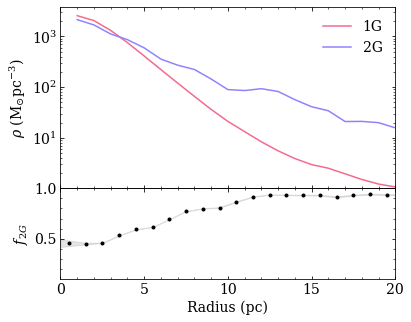

In [19]:
X = bin_edges[1:]

fig, ax = plt.subplots(1,1)
fig.set_size_inches(6, 5)
gs = gridspec.GridSpec(2, 1, height_ratios=[1,0.5])  

ax1 = plt.subplot(gs[1]) # top left
ax0 = plt.subplot(gs[0], sharex=ax1) # top middle
plt.setp(ax0.get_xticklabels(), visible=False)

ax0.plot(X, sigma_o, color = old_col, label=r'1G', linewidth=1.5)
ax0.plot(X, sigma_n, color = new_col, label=r'2G', linewidth=1.5)
ax0.legend(fancybox=False,  frameon=False)
ax0.set_yscale('log')
ax0.xaxis.set_minor_locator(AutoMinorLocator())
ax0.tick_params(direction='in', axis='both', which='both', bottom=True,top=True, left=True, right=True)
ax0.set_ylabel(r'$\rho \ (\rm{M}_{\odot} pc^{-3})$')
ax0.set_ylim(bottom = 1.01)

ax1.plot(bin_centers, f_enriched, 'k.')
ax1.set_xlabel('Radius (pc)')
ax1.set_ylabel('$f_{2G}$')
ax1.xaxis.set_minor_locator(AutoMinorLocator())
ax1.yaxis.set_minor_locator(AutoMinorLocator())
ax1.tick_params(direction='in', axis='both', which='both', bottom=True,top=True, left=True, right=True)
ax1.fill_between(x_range, f_lower, f_upper, alpha = 0.2, color = 'grey')
ax1.set_xlim(left = 0, right = 20)
ax1.set_ylim(bottom = 0.1, top = 1)

gs.update(wspace=0, hspace=0)   
plt.savefig('f_enriched_2',bbox_inches='tight', dpi = 300)
plt.show()

## Cumulative histograms

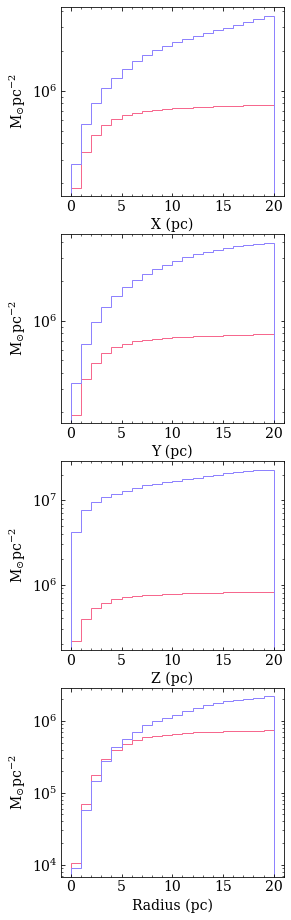

In [41]:

binning = 20
max_range = 20
fig, ax = plt.subplots(4)
fig.set_size_inches(4,16)
ax[0].hist(abs(old.x_scale), bins=binning, range=(0, max_range), cumulative = True, 
           weights = old.mass, histtype = 'step', color = old_col);
ax[0].hist(abs(new.x_scale), bins=binning, range=(0, max_range), cumulative = True, 
           weights = new.mass, histtype = 'step', color = new_col);
ax[0].set_xlabel('X (pc)')
ax[0].set_yscale('log')
ax[0].xaxis.set_minor_locator(AutoMinorLocator())
ax[0].tick_params(direction='in', axis='both', which='both', bottom=True,top=True, left=True, right=True)
ax[0].set_ylabel(r'$\rm{M}_{\odot}pc^{-2}$')

ax[1].hist(abs(old.y_scale), bins=binning, range=(0, max_range), cumulative = True, 
           weights = old.mass, histtype = 'step', color = old_col);
ax[1].hist(abs(new.y_scale), bins=binning, range=(0, max_range), cumulative = True, 
           weights = new.mass, histtype = 'step', color = new_col);
ax[1].set_xlabel('Y (pc)')
ax[1].set_yscale('log')
ax[1].xaxis.set_minor_locator(AutoMinorLocator())
ax[1].tick_params(direction='in', axis='both', which='both', bottom=True,top=True, left=True, right=True)
ax[1].set_ylabel(r'$\rm{M}_{\odot}pc^{-2}$')

ax[2].hist(abs(old.z_scale), bins=binning, range=(0, max_range), cumulative = True, 
           weights = old.mass, histtype = 'step', color = old_col);
ax[2].hist(abs(new.z_scale), bins=binning, range=(0, max_range), cumulative = True, 
           weights = new.mass, histtype = 'step', color = new_col);
ax[2].set_xlabel('Z (pc)')
ax[2].set_yscale('log')
ax[2].xaxis.set_minor_locator(AutoMinorLocator())
ax[2].tick_params(direction='in', axis='both', which='both', bottom=True,top=True, left=True, right=True)
ax[2].set_ylabel(r'$\rm{M}_{\odot}pc^{-2}$')


ax[3].hist(abs(old.r), bins=binning, range=(0, max_range), cumulative = True, 
           weights = old.mass, histtype = 'step', color = old_col);
ax[3].hist(abs(new.r), bins=binning, range=(0, max_range), cumulative = True, 
           weights = new.mass, histtype = 'step', color = new_col);
ax[3].set_xlabel('Radius (pc)')
ax[3].set_yscale('log')
ax[3].xaxis.set_minor_locator(AutoMinorLocator())
ax[3].tick_params(direction='in', axis='both', which='both', bottom=True,top=True, left=True, right=True)
ax[3].set_ylabel(r'$\rm{M}_{\odot}pc^{-2}$')

plt.savefig('cum_hist',bbox_inches='tight', dpi = 300)
plt.show()

In [42]:
new_sum = np.sum(new.loc[new.r<5].mass)
old_sum = np.sum(old.loc[old.r<5].mass)
print('new star mass: ', new_sum)
print('old star mass: ', old_sum)
print('f_enriched:    ', new_sum/(new_sum+old_sum))

new star mass:  430996.6542900001
old star mass:  395417.55
f_enriched:     0.5215261935874924


## If this is an AGB simulation

In [ ]:
new_AGB = pd.concat([new.loc[(new['id'] ==1)],
                    new.loc[(new['id'] == 2)],
                    new.loc[(new['id'] == 3)],
                    new.loc[(new['id'] == 4)],
                    new.loc[(new['id'] == 5)]])

new_ISM = pd.concat([new.loc[(new['id'] ==6)],
                    new.loc[(new['id'] == 7)],
                    new.loc[(new['id'] == 8)],
                    new.loc[(new['id'] == 9)],
                    new.loc[(new['id'] ==10)]])

In [ ]:
binning = 20
max_range = 20

#x_range = np.linspace(0,max_range,binning)
bin_centers, _, _ = stats.binned_statistic(new.r, values = new.r, statistic='mean',bins=binning, range=(0, max_range))
x_range = np.copy(bin_centers)
x_range[0] = 0
x_range[-1] = max_range

new_AGB_hist, _,_ = stats.binned_statistic(new_AGB.r, values = new_AGB.mass, statistic='sum', bins=binning, range=(0, max_range))
new_ISM_hist, _,_ = stats.binned_statistic(new_ISM.r, values = new_ISM.mass, statistic='sum', bins=binning, range=(0, max_range))

new_AGB_std, _,_ = stats.binned_statistic(new_AGB.r, values = new_AGB.mass, statistic='std', bins=binning, range=(0, max_range))
new_ISM_std, _,_ = stats.binned_statistic(new_ISM.r, values = new_ISM.mass, statistic='std', bins=binning, range=(0, max_range))

num_std_30 = 0.30*new_ISM_std + 0.25*new_AGB_std
num_std_34 = 0.34*new_ISM_std + 0.25*new_AGB_std
num_std_38 = 0.38*new_ISM_std + 0.25*new_AGB_std

den_std = new_ISM_std - new_AGB_std

std_30 = np.sqrt(((num_std_30/(new_AGB_hist+new_ISM_hist))**2 + (den_std/(new_AGB_hist+new_ISM_hist))**2))
std_34 = np.sqrt(((num_std_34/(new_AGB_hist+new_ISM_hist))**2 + (den_std/(new_AGB_hist+new_ISM_hist))**2))
std_38 = np.sqrt(((num_std_38/(new_AGB_hist+new_ISM_hist))**2 + (den_std/(new_AGB_hist+new_ISM_hist))**2))

upper_ISM = new_ISM_hist + new_ISM_std
lower_ISM = new_ISM_hist + new_ISM_std

he_30_abundance = (0.30*new_AGB_hist + 0.25*new_ISM_hist)/(new_AGB_hist+new_ISM_hist)
he_34_abundance = (0.34*new_AGB_hist + 0.25*new_ISM_hist)/(new_AGB_hist+new_ISM_hist)
he_38_abundance = (0.38*new_AGB_hist + 0.25*new_ISM_hist)/(new_AGB_hist+new_ISM_hist)


he_30__low_abundance = he_30_abundance - std_30
he_30__upp_abundance = he_30_abundance + std_30

he_34__low_abundance = he_34_abundance - std_34
he_34__upp_abundance = he_34_abundance + std_34

he_38__low_abundance = he_38_abundance - std_38
he_38__upp_abundance = he_38_abundance + std_38

fig, ax = plt.subplots()
#fig.set_size_inches(4,16)
fig.set_size_inches(6, 4)
'''ax.scatter(bin_centers, he_38_abundance,  color = 'lightskyblue', label = '$Y_{AGB} = 0.38$')
ax.fill_between(x_range, he_38__low_abundance, he_38__upp_abundance, alpha = 0.2, color = 'lightskyblue')

ax.scatter(bin_centers, he_34_abundance, marker ='H', color = 'royalblue', label = '$Y_{AGB} = 0.34$')
ax.fill_between(x_range, he_34__low_abundance, he_34__upp_abundance, alpha = 0.2,  color = 'royalblue')

ax.scatter(bin_centers, he_30_abundance, marker ='p', color = 'navy', label = '$Y_{AGB} = 0.30$')
ax.fill_between(x_range, he_30__low_abundance, he_30__upp_abundance, alpha = 0.2, color = 'navy')'''

ax.scatter(bin_centers, he_38_abundance,  color = '#4FC6E3', label = '$Y_{AGB} = 0.38$')
ax.fill_between(x_range, he_38__low_abundance, he_38__upp_abundance, alpha = 0.2, color = '#4FC6E3')

ax.scatter(bin_centers, he_34_abundance, marker ='H', color = '#47859A', label = '$Y_{AGB} = 0.34$')
ax.fill_between(x_range, he_34__low_abundance, he_34__upp_abundance, alpha = 0.2,  color = '#47859A')

ax.scatter(bin_centers, he_30_abundance, marker ='p', color = '#6F7478', label = '$Y_{AGB} = 0.30$')
ax.fill_between(x_range, he_30__low_abundance, he_30__upp_abundance, alpha = 0.2, color = '#6F7478')


ax.set_xlabel('Radius (pc)')
ax.set_ylabel('$Y_{2G}$')
ax.set_ylim(bottom = 0.25, top = 0.269)
ax.set_xlim(left = 0, right = 20)
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.tick_params(direction='in', axis='both', which='both', bottom=True,top=True, left=True, right=True)
plt.legend(fancybox=False,  frameon=False)
plt.savefig('he_abundance',bbox_inches='tight', dpi = 300)

## If this is an in-situ simulation

In [43]:
new_in = new.loc[(new['id'] ==2)]
new_ex = new.loc[(new['id'] ==1)]

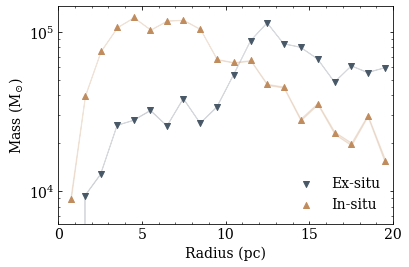

In [65]:
binning = 20
max_range = 20

bin_centers, _, _ = stats.binned_statistic(new.r, values = new.r, statistic='mean',bins=binning, range=(0, max_range))

new_ex_hist, _,_ = stats.binned_statistic(new_ex.r, values = new_ex.mass, statistic='sum', bins=binning, range=(0, max_range))
new_in_hist, _,_ = stats.binned_statistic(new_in.r, values = new_in.mass, statistic='sum', bins=binning, range=(0, max_range))

new_ex_std, _,_ = stats.binned_statistic(new_ex.r, values = new_ex.mass, statistic='std', bins=binning, range=(0, max_range))
new_in_std, _,_ = stats.binned_statistic(new_in.r, values = new_in.mass, statistic='std', bins=binning, range=(0, max_range))



new_ex_upper = new_ex_hist + new_ex_std
new_ex_lower = new_ex_hist - new_ex_std

new_in_upper = new_in_hist + new_in_std
new_in_lower = new_in_hist - new_in_std

fig, ax = plt.subplots()
#fig.set_size_inches(4,16)
fig.set_size_inches(6, 4)
'''ax.scatter(bin_centers, new_ex_hist, label = 'Ex-situ', color = 'magenta', marker = "v")
ax.fill_between(bin_centers, new_ex_lower, new_ex_upper, alpha = 0.2, color = 'magenta')

ax.scatter(bin_centers, new_in_hist, label = 'In-situ', color = 'springgreen', marker = "^")
ax.fill_between(bin_centers, new_in_lower, new_in_upper, alpha = 0.2, color = 'springgreen')'''


'''ax.scatter(bin_centers, new_ex_hist, label = 'Ex-situ', color = '#5F0F40', marker = "v")
ax.fill_between(bin_centers, new_ex_lower, new_ex_upper, alpha = 0.2, color = '#5F0F40')

ax.scatter(bin_centers, new_in_hist, label = 'In-situ', color = '#0F4C5C', marker = "^")
ax.fill_between(bin_centers, new_in_lower, new_in_upper, alpha = 0.2, color = '#0F4C5C')'''


ax.scatter(bin_centers, new_ex_hist, label = 'Ex-situ', color = '#495867', marker = "v")
ax.fill_between(bin_centers, new_ex_lower, new_ex_upper, alpha = 0.2, color = '#495867')

ax.scatter(bin_centers, new_in_hist, label = 'In-situ', color = '#C18C5D', marker = "^")
ax.fill_between(bin_centers, new_in_lower, new_in_upper, alpha = 0.2, color = '#C18C5D')


ax.set_yscale('log')
ax.set_xlabel('Radius (pc)')
ax.set_ylabel(r'Mass ($\rm{M}_{\odot}$)')
plt.legend(fancybox = False, frameon=False)
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.set_xlim(left = 0, right = 20)
#ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.tick_params(direction='in', axis='both', which='both', bottom=True,top=True, left=True, right=True)
plt.savefig('in_ex_situ_2',bbox_inches='tight', dpi = 300)
plt.show()

In [ ]:
def init_metal_grad_kde(gas, id1, id2):
    
    fig, ax = plt.subplots(1,1)
    fig.set_size_inches(6,4)

    id1_ratio = id1.size/gas.size
    id2_ratio = id2.size/gas.size
    
    kde = stats.gaussian_kde(id1)
    id1_linspace = np.linspace(0, gas.max(), 1000)
    ax.plot(id1_linspace, kde(id1_linspace)*id1_ratio,label='Ex-situ', color='xkcd:candy pink')

    kde = stats.gaussian_kde(id2)
    id2_linspace = np.linspace(0, gas.max(), 1000)
    ax.plot(id2_linspace, kde(id2_linspace)*id2_ratio,label='In-situ', color='xkcd:mint green')

    kde = stats.gaussian_kde(gas)
    gas_linspace = np.linspace(0, gas.max(), 1000)
    ax.fill_between(gas_linspace, kde(gas_linspace), label = 'Total 2G', color='xkcd:midnight purple', alpha = 0.2)



    ax.tick_params(direction='in', axis='both', which='both', bottom=True,top=True, left=True, right=True)
    ax.set_xlabel("Radius (pc)")
    ax.set_ylabel("Probability Density")
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())
    ax.set_xlim(left=0, right=gas.max())
    ax.set_ylim(bottom=0)

    ax.legend(fancybox=False)
    plt.savefig('init_metal_gradient_kde',bbox_inches='tight', dpi = 300)

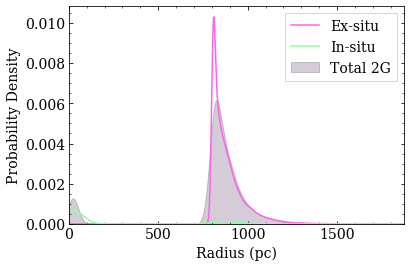

In [64]:
init_metal_grad_kde(new[new.r<20], new_ex[new_ex., new_in.mass)

## Velocity centering

In [ ]:
# Take the best estmate of the clusters mean velosity as that of the 1G within 10 pc
old_10  = old.loc[old.r<10]

vx_scale = np.mean(old_10.vx)
vy_scale = np.mean(old_10.vy)
vz_scale = np.mean(old_10.vz)

old = old.assign(vx_scale = old.vx - vx_scale)
old = old.assign(vy_scale = old.vy - vy_scale)
old = old.assign(vz_scale = old.vz - vz_scale)

new = new.assign(vx_scale = new.vx - vx_scale)
new = new.assign(vy_scale = new.vy - vy_scale)
new = new.assign(vz_scale = new.vz - vz_scale)

In [ ]:
old_vx = 0
old_vy = 0
old_vz = 0

new_vx = 0
new_vy = 0
new_vz = 0


def get_theta(arr):
    angles = np.arctan2(arr['y_scale'],arr['x_scale'])
    angles = (2*np.pi + angles) * (angles < 0) + angles*(angles > 0)
    arr = arr.assign(theta = angles)

    return arr

def get_angles_arr():
    # because its gross and ugly and I want to hide my hard coding shame
    return [0, 0.39269908169872414, 0.7853981633974483, 1.1780972450961724, 1.5707963267948966, 
            1.9634954084936207, 2.356194490192345, 2.748893571891069, 3.141592653589793, 3.5342917352885173, 
            3.9269908169872414, 4.319689898685965, 4.71238898038469, 5.105088062083414, 5.497787143782138, 
            5.890486225480862, 6.283185307179586]

def polar_split(arr_ns, arr_gc):
    arr_ns = get_theta(arr_ns)
    arr_gc = get_theta(arr_gc)
   


    # Hard code in array bounds - not going to change at any point (always 16 slices)
    angles_arr = get_angles_arr()

    gc_vy = []    # empty list to append average vy values to
    gc_vz = []
    gc_vx = []

    gc_vy_std = []    # empty list to append average vy values to
    gc_vz_std = []
    gc_vx_std = []

    ns_vy = []
    ns_vz = []
    ns_vx = []

    ns_vy_std = []
    ns_vz_std = []
    ns_vx_std = []
    
    for i in range(1, 17): # For indexing the angles array
        temp_ns = arr_ns.loc[ (arr_ns['theta'] < angles_arr[i]) & (arr_ns['theta'] > angles_arr[i-1]) ]
        temp_gc = arr_gc.loc[ (arr_gc['theta'] < angles_arr[i]) & (arr_gc['theta'] > angles_arr[i-1]) ]

        gc_vy.append(temp_gc['vy_scale'].mean())
        gc_vz.append(temp_gc['vz_scale'].mean())
        gc_vx.append(temp_gc['vx_scale'].mean())

        ns_vy.append(temp_ns['vy_scale'].mean())
        ns_vz.append(temp_ns['vz_scale'].mean())
        ns_vx.append(temp_ns['vx_scale'].mean())


        gc_vy_std.append(temp_gc['vy_scale'].std())
        gc_vz_std.append(temp_gc['vz_scale'].std())
        gc_vx_std.append(temp_gc['vx_scale'].std())

        ns_vy_std.append(temp_ns['vy_scale'].std())
        ns_vz_std.append(temp_ns['vz_scale'].std())
        ns_vx_std.append(temp_ns['vx_scale'].std())

    v_av_vals = pd.DataFrame({'gc_vy':gc_vy, 'gc_vz':gc_vz, 'gc_vx':gc_vx, 'ns_vy':ns_vy, 'ns_vz':ns_vz, 'ns_vx':ns_vx, 'gc_vy_std':gc_vy_std, 'gc_vz_std':gc_vz_std, 'gc_vx_std':gc_vx_std, 'ns_vy_std':ns_vy_std, 'ns_vz_std':ns_vz_std, 'ns_vx_std':ns_vx_std})
    
    
    return v_av_vals

def get_cartesian_points(rad_val):
    angles_arr = get_angles_arr()
    angles_arr = np.delete(angles_arr, 0) # delete the 0 at the beginning
    mid_angle = 2* np.pi/32

    mid_angle_arr = angles_arr - mid_angle

    x_rad = rad_val * np.cos(mid_angle_arr)
    y_rad = rad_val * np.sin(mid_angle_arr)

    return x_rad, y_rad

def sine_fit(x, a, b, c, d):
    return a * np.sin(b * x +c)+d

def rot_theta__overlay_plot(theta, rot_arr):

    # Use graphics grid to put legend into its own axis
    params_gcx, params_covariance = optimize.curve_fit(sine_fit, theta, rot_arr.gc_vx, p0=[10, 0.017, 0, 0])
    params_gcy, params_covariance = optimize.curve_fit(sine_fit, theta, rot_arr.gc_vy, p0=[10, 0.017, 0, 0])
    params_gcz, params_covariance = optimize.curve_fit(sine_fit, theta, rot_arr.gc_vz, p0=[1, 0.017, 0, 0])
    
    no_nan_new_x = rot_arr.ns_vx[~np.isnan(rot_arr.ns_vx)]
    no_nan_theta_x = theta[~np.isnan(rot_arr.ns_vx)]
    no_nan_new_y = rot_arr.ns_vy[~np.isnan(rot_arr.ns_vy)]
    no_nan_theta_y = theta[~np.isnan(rot_arr.ns_vy)]
    no_nan_new_z = rot_arr.ns_vz[~np.isnan(rot_arr.ns_vz)]
    no_nan_theta_z = theta[~np.isnan(rot_arr.ns_vz)]
    
    params_nsx, params_covariance = optimize.curve_fit(sine_fit, no_nan_theta_x, no_nan_new_x, p0=[10, 0.017, 0, 0])
    params_nsy, params_covariance = optimize.curve_fit(sine_fit, no_nan_theta_y, no_nan_new_y, p0=[10, 0.017, 0, 0])
    params_nsz, params_covariance = optimize.curve_fit(sine_fit, no_nan_theta_z, no_nan_new_z, p0=[1, 0.017, 0, 0])

    fig, ax = plt.subplots(3,1, sharex=True, sharey=True)
    fig.set_size_inches(6, 9)
    
    ax[0].scatter(theta, rot_arr.gc_vx, color=old_col, marker='s', label='1G')
    # Add this to put the 1 sigma axis back in label=r'1 $\sigma$' 
    ax[0].fill_between(theta, rot_arr.gc_vx - rot_arr.gc_vx_std, rot_arr.gc_vx + rot_arr.gc_vx_std, color='r', alpha=0.2)
    ax[0].plot(theta, sine_fit(theta, params_gcx[0], params_gcx[1], params_gcx[2], params_gcx[3]), color='r', alpha=0.5, zorder=-2)
    ax[0].set_ylabel("$V_x$ (km$s^{-1})$")
    

    ax[1].scatter(theta, rot_arr.gc_vy, color=old_col, marker='s', label='1G')
    ax[1].fill_between(theta, rot_arr.gc_vy - rot_arr.gc_vy_std, rot_arr.gc_vy + rot_arr.gc_vy_std, color='r', alpha=0.2)
    ax[1].plot(theta, sine_fit(theta, params_gcy[0], params_gcy[1], params_gcy[2], params_gcy[3]), color='r', alpha=0.5, zorder=-2)
    ax[1].set_ylabel("$V_y$ (km$s^{-1}$)")
    
    

    ax[2].scatter(theta, rot_arr.gc_vz, color=old_col, marker='s', label='1G')
    ax[2].fill_between(theta, rot_arr.gc_vz - rot_arr.gc_vz_std, rot_arr.gc_vz + rot_arr.gc_vz_std, color='r', alpha=0.2)
    ax[2].plot(theta, sine_fit(theta, params_gcz[0], params_gcz[1], params_gcz[2], params_gcz[3]), color='r', alpha=0.5, zorder=-2)
    ax[2].set_ylabel("$V_z$ (km$s^{-1}$)")
    
    

    ax[0].scatter(theta, rot_arr.ns_vx, color=new_col, marker='D', label='2G')
    ax[0].fill_between(theta, rot_arr.ns_vx - rot_arr.ns_vx_std, rot_arr.ns_vx + rot_arr.ns_vx_std, color='b', alpha=0.2)
    ax[0].plot(theta, sine_fit(theta, params_nsx[0], params_nsx[1], params_nsx[2], params_nsx[3]), color='b', alpha=0.5, zorder=-1)
    ax[1].scatter(theta, rot_arr.ns_vy, color=new_col, marker='D', label='2G')
    ax[1].fill_between(theta, rot_arr.ns_vy - rot_arr.ns_vy_std, rot_arr.ns_vy + rot_arr.ns_vy_std, color='b', alpha=0.2)
    ax[1].plot(theta, sine_fit(theta, params_nsy[0], params_nsy[1], params_nsy[2], params_nsy[3]), color='b', alpha=0.5, zorder=-2)
    ax[2].scatter(theta, rot_arr.ns_vz, color=new_col, marker='D', label='2G')
    ax[2].fill_between(theta, rot_arr.ns_vz - rot_arr.ns_vz_std, rot_arr.ns_vz + rot_arr.ns_vz_std, color='b', alpha=0.2)
    ax[2].plot(theta, sine_fit(theta, params_nsz[0], params_nsz[1], params_nsz[2], params_nsz[3]), color='b', alpha=0.5, zorder=-2)
    ax[2].xaxis.set_ticks(np.arange(0, 721, 90))
    ax[2].set_xlabel(r"$\theta$ (deg)")
    
    print('average new vx std', np.mean(rot_arr.ns_vx_std))
    print('average new vy std', np.mean(rot_arr.ns_vy_std))
    print('average new vz std', np.mean(rot_arr.ns_vz_std))
    
    print('average old vx std', np.mean(rot_arr.gc_vx_std))
    print('average old vy std', np.mean(rot_arr.gc_vy_std))
    print('average old vz std', np.mean(rot_arr._vz_std))

    # Want it on top of the top axis
    ax[0].legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,ncol=2, mode="expand", borderaxespad=0., edgecolor='0', fancybox=False, frameon=True)
    ax[0].xaxis.set_minor_locator(AutoMinorLocator())
    ax[0].yaxis.set_minor_locator(AutoMinorLocator())

    ax[1].xaxis.set_minor_locator(AutoMinorLocator())
    ax[1].yaxis.set_minor_locator(AutoMinorLocator())

    ax[1].xaxis.set_minor_locator(AutoMinorLocator())
    ax[1].yaxis.set_minor_locator(AutoMinorLocator())

    ax[0].tick_params(direction='in', axis='both', which='both', bottom=True,top=True, left=True, right=True)
    ax[1].tick_params(direction='in', axis='both', which='both', bottom=True,top=True, left=True, right=True)
    ax[2].tick_params(direction='in', axis='both', which='both', bottom=True,top=True, left=True, right=True)

    ax[0].set_xlim(left = 0,right = 720)

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.savefig('polar_rotation', bbox_inches='tight', dpi = 300)
    #plt.tight_layout()

    #write_rotation(params_gcx[0], params_gcy[0], params_gcz[0], params_nsx[0], params_nsy[0], params_nsz[0])
    print(params_gcx[0], params_gcy[0], params_gcz[0], params_nsx[0], params_nsy[0], params_nsz[0])
    
    return params_gcx[0], params_gcy[0], params_gcz[0], params_nsx[0], params_nsy[0], params_nsz[0]

def polar_plotter(arr_ns, arr_gc):
    # Returns the median velosities of the polar vals
    v_av_vals = polar_split(arr_ns, arr_gc)
    
    x_rad, y_rad = get_cartesian_points(5)
    
    # Make angle array for the mid points
    angle_arr_2 = []
    for i in range(0,32):
        angle_arr_2.append(np.degrees((2*np.pi/16*i)+(2*np.pi/32)))

    angle_arr_2 = np.asarray(angle_arr_2)
    v_av_vals_2 = pd.concat([v_av_vals, v_av_vals])
    

    old_vx, old_vy, old_vz, new_vx, new_vy, new_vz = rot_theta__overlay_plot(angle_arr_2, v_av_vals_2)
    return 

old_vx, old_vy, old_vz, new_vx, new_vy, new_vz = polar_plotter(new.loc[new.r<30], old.loc[old.r<30])
    

In [ ]:
old_vx = 0
old_vy = 0
old_vz = 0

new_vx = 0
new_vy = 0
new_vz = 0


def get_theta(arr):
    angles = np.arctan2(arr['y_scale'],arr['x_scale'])
    angles = (2*np.pi + angles) * (angles < 0) + angles*(angles > 0)
    arr = arr.assign(theta = angles)

    return arr

def get_angles_arr():
    # because its gross and ugly and I want to hide my hard coding shame
    return [0, 0.39269908169872414, 0.7853981633974483, 1.1780972450961724, 1.5707963267948966, 
            1.9634954084936207, 2.356194490192345, 2.748893571891069, 3.141592653589793, 3.5342917352885173, 
            3.9269908169872414, 4.319689898685965, 4.71238898038469, 5.105088062083414, 5.497787143782138, 
            5.890486225480862, 6.283185307179586]

def polar_split(arr_ns, arr_gc):
    arr_ns = get_theta(arr_ns)
    arr_gc = get_theta(arr_gc)
   


    # Hard code in array bounds - not going to change at any point (always 16 slices)
    angles_arr = get_angles_arr()

    gc_vy = []    # empty list to append average vy values to
    gc_vz = []
    gc_vx = []

    gc_vy_std = []    # empty list to append average vy values to
    gc_vz_std = []
    gc_vx_std = []

    ns_vy = []
    ns_vz = []
    ns_vx = []

    ns_vy_std = []
    ns_vz_std = []
    ns_vx_std = []
    
    for i in range(1, 17): # For indexing the angles array
        temp_ns = arr_ns.loc[ (arr_ns['theta'] < angles_arr[i]) & (arr_ns['theta'] > angles_arr[i-1]) ]
        temp_gc = arr_gc.loc[ (arr_gc['theta'] < angles_arr[i]) & (arr_gc['theta'] > angles_arr[i-1]) ]

        gc_vy.append(temp_gc['vy_scale'].mean())
        gc_vz.append(temp_gc['vz_scale'].mean())
        gc_vx.append(temp_gc['vx_scale'].mean())

        ns_vy.append(temp_ns['vy_scale'].mean())
        ns_vz.append(temp_ns['vz_scale'].mean())
        ns_vx.append(temp_ns['vx_scale'].mean())


        gc_vy_std.append(temp_gc['vy_scale'].std())
        gc_vz_std.append(temp_gc['vz_scale'].std())
        gc_vx_std.append(temp_gc['vx_scale'].std())

        ns_vy_std.append(temp_ns['vy_scale'].std())
        ns_vz_std.append(temp_ns['vz_scale'].std())
        ns_vx_std.append(temp_ns['vx_scale'].std())

    v_av_vals = pd.DataFrame({'gc_vy':gc_vy, 'gc_vz':gc_vz, 'gc_vx':gc_vx, 'ns_vy':ns_vy, 'ns_vz':ns_vz, 'ns_vx':ns_vx, 'gc_vy_std':gc_vy_std, 'gc_vz_std':gc_vz_std, 'gc_vx_std':gc_vx_std, 'ns_vy_std':ns_vy_std, 'ns_vz_std':ns_vz_std, 'ns_vx_std':ns_vx_std})
    
    
    return v_av_vals

def get_cartesian_points(rad_val):
    angles_arr = get_angles_arr()
    angles_arr = np.delete(angles_arr, 0) # delete the 0 at the beginning
    mid_angle = 2* np.pi/32

    mid_angle_arr = angles_arr - mid_angle

    x_rad = rad_val * np.cos(mid_angle_arr)
    y_rad = rad_val * np.sin(mid_angle_arr)

    return x_rad, y_rad

def sine_fit(x, a, b, c, d):
    return a * np.sin(b * x +c)+d

def rot_theta__overlay_plot(theta, rot_arr):

    # Use graphics grid to put legend into its own axis
    params_gcx, params_covariance = optimize.curve_fit(sine_fit, theta, rot_arr.gc_vx, p0=[10, 0.017, 0, 0])
    params_gcy, params_covariance = optimize.curve_fit(sine_fit, theta, rot_arr.gc_vy, p0=[10, 0.017, 0, 0])
    params_gcz, params_covariance = optimize.curve_fit(sine_fit, theta, rot_arr.gc_vz, p0=[1, 0.017, 0, 0])
    
    no_nan_new_x = rot_arr.ns_vx[~np.isnan(rot_arr.ns_vx)]
    no_nan_theta_x = theta[~np.isnan(rot_arr.ns_vx)]
    no_nan_new_y = rot_arr.ns_vy[~np.isnan(rot_arr.ns_vy)]
    no_nan_theta_y = theta[~np.isnan(rot_arr.ns_vy)]
    no_nan_new_z = rot_arr.ns_vz[~np.isnan(rot_arr.ns_vz)]
    no_nan_theta_z = theta[~np.isnan(rot_arr.ns_vz)]
    
    params_nsx, params_covariance = optimize.curve_fit(sine_fit, no_nan_theta_x, no_nan_new_x, p0=[10, 0.017, 0, 0])
    params_nsy, params_covariance = optimize.curve_fit(sine_fit, no_nan_theta_y, no_nan_new_y, p0=[10, 0.017, 0, 0])
    params_nsz, params_covariance = optimize.curve_fit(sine_fit, no_nan_theta_z, no_nan_new_z, p0=[1, 0.017, 0, 0])

    fig, ax = plt.subplots(3,1, sharex=True, sharey=True)
    fig.set_size_inches(6, 9)
    
    ax[0].scatter(theta, rot_arr.gc_vx, color=old_col, marker='s', label='1G')
    # Add this to put the 1 sigma axis back in label=r'1 $\sigma$' 
    ax[0].fill_between(theta, rot_arr.gc_vx - rot_arr.gc_vx_std, rot_arr.gc_vx + rot_arr.gc_vx_std, color='r', alpha=0.2)
    ax[0].plot(theta, sine_fit(theta, params_gcx[0], params_gcx[1], params_gcx[2], params_gcx[3]), color='r', alpha=0.5, zorder=-2)
    ax[0].set_ylabel("$V_x$ (km$s^{-1})$")
    

    ax[1].scatter(theta, rot_arr.gc_vy, color=old_col, marker='s', label='1G')
    ax[1].fill_between(theta, rot_arr.gc_vy - rot_arr.gc_vy_std, rot_arr.gc_vy + rot_arr.gc_vy_std, color='r', alpha=0.2)
    ax[1].plot(theta, sine_fit(theta, params_gcy[0], params_gcy[1], params_gcy[2], params_gcy[3]), color='r', alpha=0.5, zorder=-2)
    ax[1].set_ylabel("$V_y$ (km$s^{-1}$)")
    
    

    ax[2].scatter(theta, rot_arr.gc_vz, color=old_col, marker='s', label='1G')
    ax[2].fill_between(theta, rot_arr.gc_vz - rot_arr.gc_vz_std, rot_arr.gc_vz + rot_arr.gc_vz_std, color='r', alpha=0.2)
    ax[2].plot(theta, sine_fit(theta, params_gcz[0], params_gcz[1], params_gcz[2], params_gcz[3]), color='r', alpha=0.5, zorder=-2)
    ax[2].set_ylabel("$V_z$ (km$s^{-1}$)")
    
    

    ax[0].scatter(theta, rot_arr.ns_vx, color=new_col, marker='D', label='2G')
    ax[0].fill_between(theta, rot_arr.ns_vx - rot_arr.ns_vx_std, rot_arr.ns_vx + rot_arr.ns_vx_std, color='b', alpha=0.2)
    ax[0].plot(theta, sine_fit(theta, params_nsx[0], params_nsx[1], params_nsx[2], params_nsx[3]), color='b', alpha=0.5, zorder=-1)
    ax[1].scatter(theta, rot_arr.ns_vy, color=new_col, marker='D', label='2G')
    ax[1].fill_between(theta, rot_arr.ns_vy - rot_arr.ns_vy_std, rot_arr.ns_vy + rot_arr.ns_vy_std, color='b', alpha=0.2)
    ax[1].plot(theta, sine_fit(theta, params_nsy[0], params_nsy[1], params_nsy[2], params_nsy[3]), color='b', alpha=0.5, zorder=-2)
    ax[2].scatter(theta, rot_arr.ns_vz, color=new_col, marker='D', label='2G')
    ax[2].fill_between(theta, rot_arr.ns_vz - rot_arr.ns_vz_std, rot_arr.ns_vz + rot_arr.ns_vz_std, color='b', alpha=0.2)
    ax[2].plot(theta, sine_fit(theta, params_nsz[0], params_nsz[1], params_nsz[2], params_nsz[3]), color='b', alpha=0.5, zorder=-2)
    ax[2].xaxis.set_ticks(np.arange(0, 721, 90))
    ax[2].set_xlabel(r"$\theta$ (deg)")
    
    print('average new vx std', np.mean(rot_arr.ns_vx_std))
    print('average new vy std', np.mean(rot_arr.ns_vy_std))
    print('average new vz std', np.mean(rot_arr.ns_vz_std))
    
    print('average old vx std', np.mean(rot_arr.gc_vx_std))
    print('average old vy std', np.mean(rot_arr.gc_vy_std))
    print('average old vz std', np.mean(rot_arr.gc_vz_std))

    # Want it on top of the top axis
    ax[0].legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,ncol=2, mode="expand", borderaxespad=0., edgecolor='0', fancybox=False, frameon=True)
    ax[0].xaxis.set_minor_locator(AutoMinorLocator())
    ax[0].yaxis.set_minor_locator(AutoMinorLocator())

    ax[1].xaxis.set_minor_locator(AutoMinorLocator())
    ax[1].yaxis.set_minor_locator(AutoMinorLocator())

    ax[1].xaxis.set_minor_locator(AutoMinorLocator())
    ax[1].yaxis.set_minor_locator(AutoMinorLocator())

    ax[0].tick_params(direction='in', axis='both', which='both', bottom=True,top=True, left=True, right=True)
    ax[1].tick_params(direction='in', axis='both', which='both', bottom=True,top=True, left=True, right=True)
    ax[2].tick_params(direction='in', axis='both', which='both', bottom=True,top=True, left=True, right=True)

    ax[0].set_xlim(left = 0,right = 720)

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.savefig('polar_rotation', bbox_inches='tight', dpi = 300)
    #plt.tight_layout()

    #write_rotation(params_gcx[0], params_gcy[0], params_gcz[0], params_nsx[0], params_nsy[0], params_nsz[0])
    print(params_gcx[0], params_gcy[0], params_gcz[0], params_nsx[0], params_nsy[0], params_nsz[0])
    
    return params_gcx[0], params_gcy[0], params_gcz[0], params_nsx[0], params_nsy[0], params_nsz[0]

def polar_plotter(arr_ns, arr_gc):
    # Returns the median velosities of the polar vals
    v_av_vals = polar_split(arr_ns, arr_gc)
    
    x_rad, y_rad = get_cartesian_points(5)
    
    # Make angle array for the mid points
    angle_arr_2 = []
    for i in range(0,32):
        angle_arr_2.append(np.degrees((2*np.pi/16*i)+(2*np.pi/32)))

    angle_arr_2 = np.asarray(angle_arr_2)
    v_av_vals_2 = pd.concat([v_av_vals, v_av_vals])
    

    old_vx, old_vy, old_vz, new_vx, new_vy, new_vz = rot_theta__overlay_plot(angle_arr_2, v_av_vals_2)
    return 

old_vx, old_vy, old_vz, new_vx, new_vy, new_vz = polar_plotter(new.loc[new.r<30], old.loc[old.r<30])
    

## Import Gas and Gal along for the ride

In [20]:
gal = gal.assign(x_scale = gal.x - max_dense_x - iwas4[0])
gal = gal.assign(y_scale = gal.y - max_dense_y - iwas4[1])
gal = gal.assign(z_scale = gal.z - max_dense_z - iwas4[2])

gas = gas.assign(x_scale = gas.x - max_dense_x - iwas4[0])
gas = gas.assign(y_scale = gas.y - max_dense_y - iwas4[1])
gas = gas.assign(z_scale = gas.z - max_dense_z - iwas4[2])

gal = gal.assign(r = np.power(np.power(gal.x_scale,2) + np.power(gal.y_scale,2) + np.power(gal.z_scale,2), 0.5))
gas = gas.assign(r = np.power(np.power(gas.x_scale,2) + np.power(gas.y_scale,2) + np.power(gas.z_scale,2), 0.5))

#### Disc star dispersion within 20 pc of the cluster
Can disc stars be captured by the clusters potential?

In [48]:
(np.std(gal[gal.r<50].vx)**2 + np.std(gal[gal.r<50].vy)**2 + np.std(gal[gal.r<50].vz)**2)**0.5 /3**0.5

14.91628835361893

In [49]:
(np.mean(gal[gal.r<50].vx**2) - np.mean(gal[gal.r<50].vx)**2) **0.5

15.241383951516935

In [21]:
(np.std(new[new.r<50].vx)**2 + np.std(new[new.r<50].vy)**2 + np.std(new[new.r<50].vz)**2)**0.5 /3**0.5

7.184461758322235

In [22]:
(np.std(old[old.r<50].vx)**2 + np.std(old[old.r<50].vy)**2 + np.std(old[old.r<50].vz)**2)**0.5 /3**0.5

11.033908884302022

In [23]:
all_GC = pd.concat([old, new])

In [24]:
(np.std(all_GC[all_GC.r<50].vx)**2 + np.std(all_GC[all_GC.r<50].vy)**2 + np.std(all_GC[all_GC.r<50].vz)**2)**0.5 /3**0.5

10.845599059821179

In [25]:
(np.std(all_GC[all_GC.r<20].vx)**2 + np.std(all_GC[all_GC.r<20].vy)**2 + np.std(all_GC[all_GC.r<20].vz)**2)**0.5 /3**0.5

10.83950135716691

In [29]:
G = 4.3e-3 # gravitational constant in pc Msun^-1 (km/s)^2

np.sqrt(G* np.sum(all_GC[all_GC.r<20].mass) / 20)

35.458573363504065

In [31]:
np.sqrt(G* 3e6 / 20)

25.39685019840059

In [33]:
np.sqrt(G* 1e6 / 20)

14.66287829861518

In [32]:
(15**2 * 20 )/ G

1046511.6279069767

## Preparing output file

In [ ]:
def mass_calc(gal, gas, new, old, i):
    gas_mass = np.sum(gas[gas.r < i].mass)
    gal_mass = np.sum(gal[gal.r < i].mass)
    new_mass = np.sum(new[new.r < i].mass)
    old_mass = np.sum(old[old.r < i].mass)
    return gas_mass, gal_mass, new_mass, old_mass

In [ ]:
f= open("center.csv","w+")

gas_mass_5, gal_mass_5, new_mass_5, old_mass_5     = mass_calc(gal, gas, new, old, 5)
gas_mass_10, gal_mass_10, new_mass_10, old_mass_10 = mass_calc(gal, gas, new, old, 10)
gas_mass_20, gal_mass_20, new_mass_20, old_mass_20 = mass_calc(gal, gas, new, old, 20)

#ordering wrong you dickhead
f.write("gal_5,gas_5,new_5,old_5,gal_1,gas_10,new_10,old_10,gal_20,gas_20,new_20,old_20,old_vx,old_vy,old_vz,new_vx,new_vy,new_vz\n")

f.write(str(gas_mass_5)+', '+str(gal_mass_5)+', '+str(new_mass_5)+', '+str(old_mass_5)+', '+
        str(gas_mass_10)+', '+str(gal_mass_10)+', '+str(new_mass_10)+', '+str(old_mass_10)+', '+
        str(gas_mass_20)+', '+str(gal_mass_20)+', '+str(new_mass_20)+', '+str(old_mass_20)+', '+
        str(old_vx)+', '+str(old_vy)+', '+str(old_vz)+', '+
        str(new_vx)+', '+str(new_vy)+', '+str(new_vz))

f.close()